### Mediapipe & OpenCV project : Drowsiness Detection (Image Test)

In [1]:
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

In [4]:
# mediapipe를 이용해 양쪽 눈에 대한 landmark(index) 포인트를 가져옴

mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

##### FaceMash 눈 감지 test

In [5]:
# EAR에 사용할 12개의(각각 6개) landmark points 지정 :   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

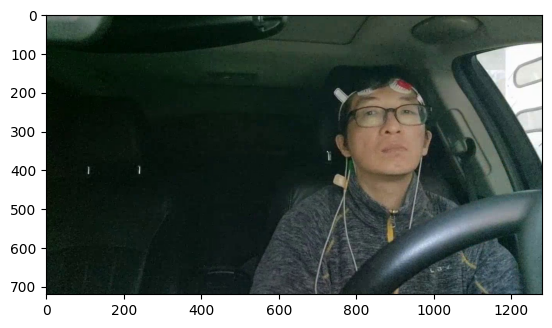

In [6]:
# load the image
image = cv2.imread('d:/drowsiness_video_data/image/SGA2100300S0042IMG0001.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB
image = np.ascontiguousarray(image) # 데이터를 빠르게 불러오기 위해 사용
imgH, imgW, _ = image.shape
 
plt.imshow(image)

In [7]:
# FaceMash 설정

with mp_facemesh.FaceMesh(
    static_image_mode=True,         # Default=False
    max_num_faces=1,                # 감지할 얼굴 수
    refine_landmarks=False,         # 눈 외의 landmark는 세분화시키지 않음
    min_detection_confidence=0.5,   # 얼굴 인식에 성공한 것으로 간주되는 최소 신뢰도
    min_tracking_confidence= 0.5,   # 성공적으로 추적한 것으로 간주되는 최소 신뢰도
) as face_mesh:
     
    results = face_mesh.process(image)
 
# 감지된 landmark points 목록
# print(bool(results.multi_face_landmarks))
results.multi_face_landmarks

[landmark {
   x: 0.7033015489578247
   y: 0.45912742614746094
   z: -0.028290485963225365
 }
 landmark {
   x: 0.7023014426231384
   y: 0.4112258553504944
   z: -0.0373716801404953
 }
 landmark {
   x: 0.7011950016021729
   y: 0.42951178550720215
   z: -0.022746574133634567
 }
 landmark {
   x: 0.6930190920829773
   y: 0.37595081329345703
   z: -0.023850560188293457
 }
 landmark {
   x: 0.7019973397254944
   y: 0.39832547307014465
   z: -0.03816428408026695
 }
 landmark {
   x: 0.7006517052650452
   y: 0.38390931487083435
   z: -0.0333290658891201
 }
 landmark {
   x: 0.6967321634292603
   y: 0.3520878851413727
   z: -0.008306478150188923
 }
 landmark {
   x: 0.6417340040206909
   y: 0.3632528483867645
   z: 0.009968019090592861
 }
 landmark {
   x: 0.6950793266296387
   y: 0.32486504316329956
   z: 0.000775612541474402
 }
 landmark {
   x: 0.6947809457778931
   y: 0.3092000484466553
   z: 0.002238653600215912
 }
 landmark {
   x: 0.6925294399261475
   y: 0.26417145133018494
   z: 0.0

In [8]:
############################# 시각화 
# 1. drawing_utils를 통해 감지된 모든 landmarks 표시
# 2. 모든 eye landmarks 표시
# 3. 지정한 eye landmarks(12개) 표시

def plot(img_dt, img_eye_lmks_chosen=None, face_landmarks=None, lmk_circle_radius=3):

    # chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen
 
    fig = plt.figure(figsize=(20, 15))
    fig.set_facecolor("white")
 
    # 각 landmark에 대한 x,y,z 좌표값
    landmarks = face_landmarks.landmark
 
    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_chosen_idxs: # 지정한 eye landmarks에 해당하는 경우
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                       )
 
    plt.imshow(img_eye_lmks_chosen)
    plt.title("Chosen landmarks", fontsize=18)
    plt.show()
    plt.close()
    return

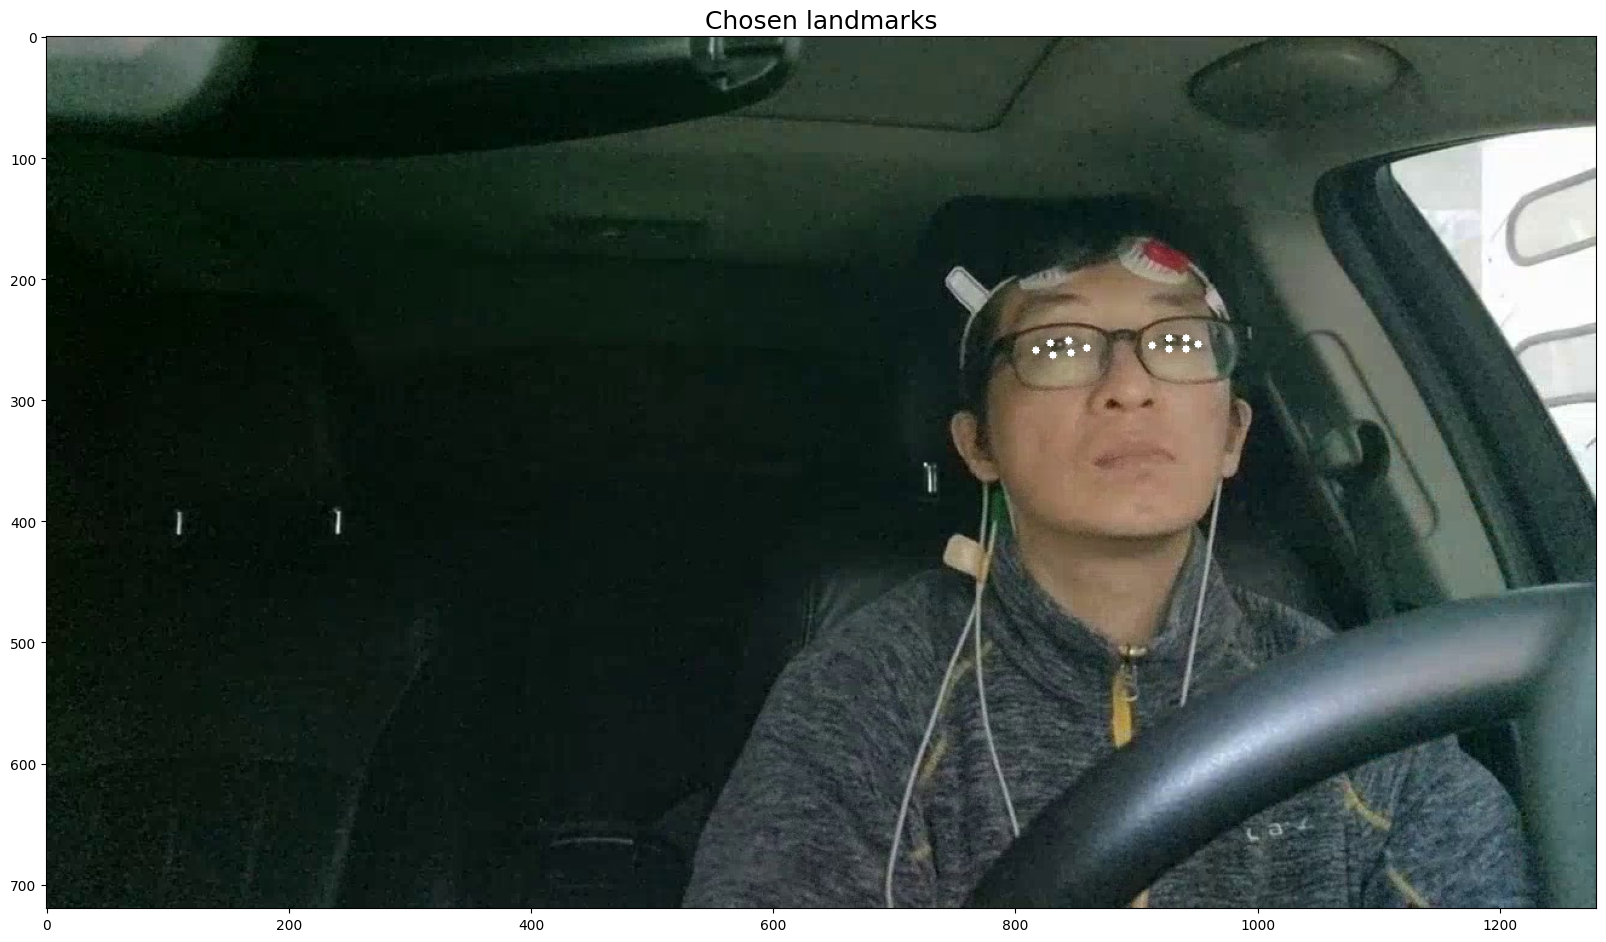

In [9]:
if results.multi_face_landmarks:
    for face_id, face_landmarks in enumerate(results.multi_face_landmarks):    
        plot(img_dt=image.copy(), face_landmarks=face_landmarks)

##### EAR 적용
    - Mediapipe의 FaceMesh를 사용해 눈 영역의 landmarks를 감지함 (관련 논문을 바탕으로 6개의 지정만 사용)
    - 눈의 높이와 너비 사이에서 EAR(Eye aspect ratio)를 계산함
    - EAR 값이 0에 가깝게 급격히 감소하는 경우 눈을 감았다고 판단함

In [10]:
def distance(point_1, point_2):
    # L2 norm 계산 (두 벡터 사이의 거리 계산)
    dist = sum([(i - j) ** 2 for i, j in zip(point_1, point_2)]) ** 0.5
    return dist

In [11]:
# EAR 공식 적용

def get_ear(landmarks, refer_idxs, frame_width, frame_height):
    # landmarks : 검출된 lanmarks list
    # refer_idxs : 검출을 위해 지정한 landmarks list [index]

    try:
        # 수평 거리 계산
        coords_points = []
        for i in refer_idxs:
            lm = landmarks[i]
            coord = denormalize_coordinates(lm.x, lm.y, frame_width, frame_height)
            coords_points.append(coord)
 
        # EAR 공식에 맞춰 P2-P6, P3-P5, P1-P4를 연산함
        P2_P6 = distance(coords_points[1], coords_points[5])
        P3_P5 = distance(coords_points[2], coords_points[4])
        P1_P4 = distance(coords_points[0], coords_points[3])
 
        ear = (P2_P6 + P3_P5) / (2.0 * P1_P4)
 
    except:
        ear = 0.0
        coords_points = None
 
    return ear, coords_points

In [12]:
def calculate_avg_ear(landmarks, left_eye_idxs, right_eye_idxs, image_w, image_h):
    
    # 왼쪽 눈의 EAR 값과 landmarks의 좌표 값을 반환함
    left_ear, left_lm_coordinates = get_ear(
                                      landmarks, 
                                      left_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    
    # 오른쪽 눈의 EAR 값과 landmarks의 좌표 값을 반환함
    right_ear, right_lm_coordinates = get_ear(
                                      landmarks, 
                                      right_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    # 최종 EAR 값을 얻기 위해 왼쪽 오른쪽의 EAR 값 평균을 계산함
    Avg_EAR = (left_ear + right_ear) / 2.0
 
    return Avg_EAR, (left_lm_coordinates, right_lm_coordinates)

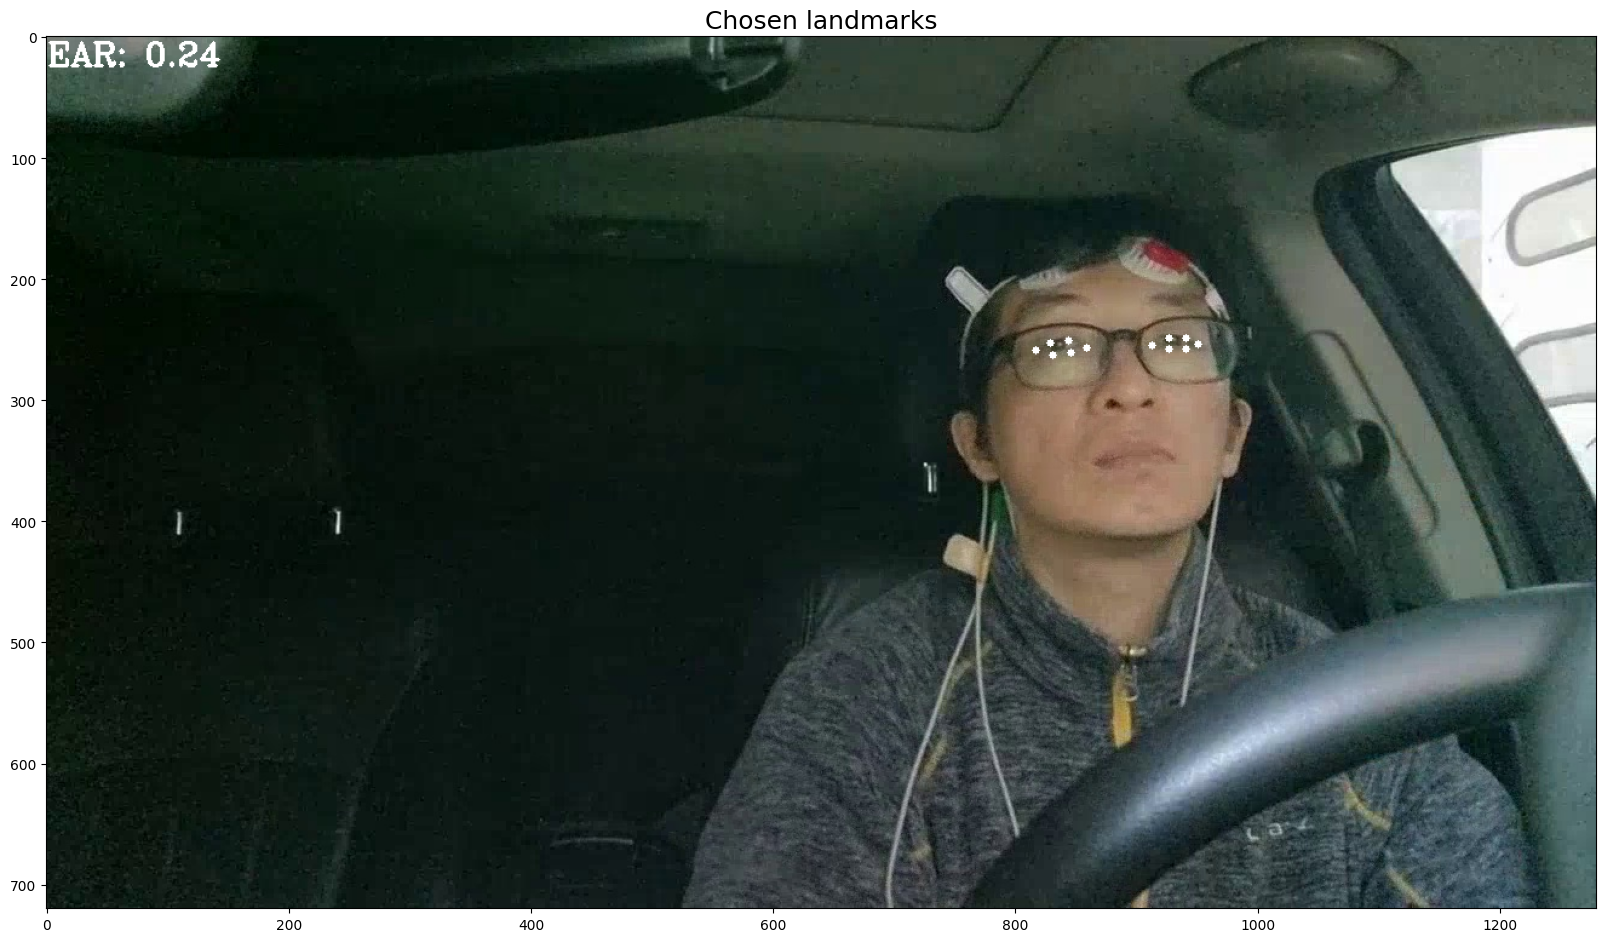

In [18]:
if results.multi_face_landmarks:
    for face_id, face_landmarks in enumerate(results.multi_face_landmarks):    
        landmarks = face_landmarks.landmark

        EAR, _ = calculate_avg_ear(
                landmarks,
                chosen_left_eye_idxs,
                chosen_right_eye_idxs,
                imgW,
                imgH
                )
        
        cv2.putText(image,
                    f"EAR: {round(EAR, 2)}", (1, 24),
                    cv2.FONT_HERSHEY_COMPLEX, 
                    0.9, (255, 255, 255), 2)

        plot(img_dt=image.copy(), face_landmarks=face_landmarks)

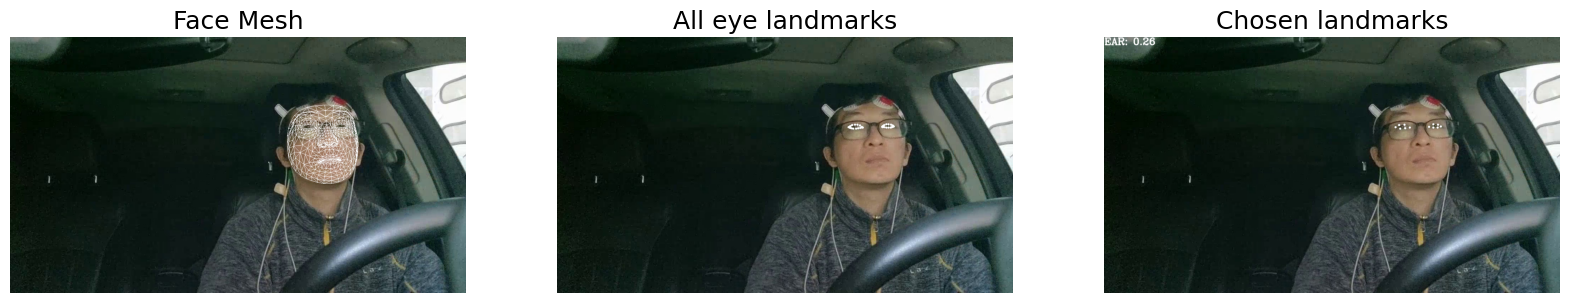

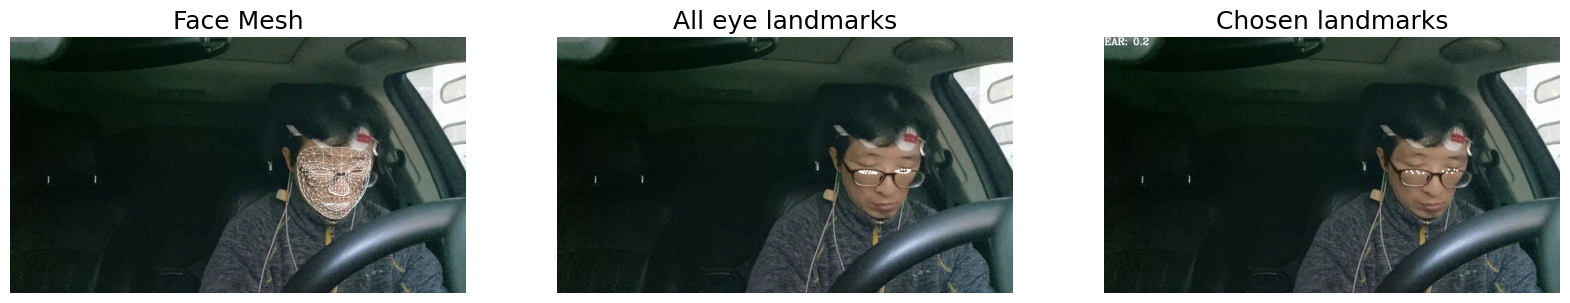

In [12]:
image_eyes_open  = cv2.imread("d:/drowsiness_video_data/image/SGA2100300S0042IMG0001.jpg")[:, :, ::-1]
image_eyes_close = cv2.imread("d:/drowsiness_video_data/image/SGA2100300S0042IMG0002.jpg")[:, :, ::-1]
 
for idx, image in enumerate([image_eyes_open, image_eyes_close]):
    
    image = np.ascontiguousarray(image) # 데이터 빨리 불러오기
    imgH, imgW, _ = image.shape
 
    custom_chosen_lmk_image = image.copy()
 
    with mp_facemesh.FaceMesh(refine_landmarks=True) as face_mesh:
        results = face_mesh.process(image).multi_face_landmarks
 
        # facemesh로 감지가 되는 경우
        if results:
            for face_id, face_landmarks in enumerate(results):
                landmarks = face_landmarks.landmark
                # 감지된 전체 landmarks 중에서 지정한 eye landmarks만 인식하여 EAR 값을 계산함
                EAR, _ = calculate_avg_ear(
                          landmarks, 
                          chosen_left_eye_idxs, 
                          chosen_right_eye_idxs, 
                          imgW, 
                          imgH
                      )
                # print(EAR, _)  
                # _ : 양측 눈의 P1..P6 좌표값
 
                # 시각화
                cv2.putText(custom_chosen_lmk_image, 
                            f"EAR: {round(EAR, 2)}", (1, 24),
                            cv2.FONT_HERSHEY_COMPLEX, 
                            0.9, (255, 255, 255), 2
                )                
              
                plot(img_dt=image.copy(),
                     img_eye_lmks_chosen=custom_chosen_lmk_image,
                     face_landmarks=face_landmarks,
                     ts_thickness=1, 
                     ts_circle_radius=3, 
                     lmk_circle_radius=3
                )